# V4-NN: Heart Sound Classification using a Neural Network

이 노트북은 **전처리된 웨이브릿 특성**을 사용하여 심장 소리를 분류하는 **신경망(Multi-Layer Perceptron)**을 훈련합니다.

**프로젝트 목표:**
1. 1차원 심장소리 데이터에서 여러 특징 추출 방식의 정확도 비교
2. 원본 .wav 데이터 vs 웨이브릿 변환 데이터의 성능 비교
3. 웨이브릿 변환을 통한 정확도 향상 효과 검증

**작업 흐름:**
1. **설정**: 전처리된 데이터 경로 설정
2. **데이터 로딩**: `wavelet_v4/` 디렉토리에서 웨이브릿 계수와 라벨 로드
3. **데이터 준비**: 훈련/테스트 세트 분할 및 특성 스케일링
4. **모델 정의**: TensorFlow/Keras를 사용한 다층 신경망 구축
5. **모델 훈련 및 평가**: 컴파일, 훈련, 성능 평가

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-07-30 03:12:07.914728: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 03:12:07.924098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 03:12:07.991818: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 03:12:08.043135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753845128.089714    1207 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753845128.10

In [2]:
# --- 1. Configuration ---
# V4 웨이브릿 데이터 경로
WAVELET_DATA_DIR = '/workspace/wavelet_v4/'

In [3]:
# --- 2. Data Loading ---
X = []
y = []

print(f"Loading V4 wavelet data from {WAVELET_DATA_DIR}...")

# Check if the directory exists
if not os.path.isdir(WAVELET_DATA_DIR):
    print(f"Error: Directory not found at {os.path.abspath(WAVELET_DATA_DIR)}")
    print("Please run the preprocessing script first: python preprocess_wavelet.py")
else:
    files = os.listdir(WAVELET_DATA_DIR)
    npz_files = [f for f in files if f.endswith('.npz')]
    
    if not npz_files:
        print(f"No .npz files found in {WAVELET_DATA_DIR}. Please run preprocessing first.")
    else:
        print(f"Found {len(npz_files)} .npz files")
        
        # Load all wavelet feature files
        for file_name in npz_files:
            path = os.path.join(WAVELET_DATA_DIR, file_name)
            try:
                data = np.load(path)
                
                # Load features and labels using the new format
                if 'features' in data and 'label' in data:
                    X.append(data['features'])
                    y.append(data['label'])
                else:
                    print(f"Warning: Expected keys 'features' and 'label' not found in {file_name}")
                    
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
        
        if X:
            # Convert to numpy arrays
            X = np.array(X)
            y = np.array(y)
            
            print(f"\n=== V4 Data Loading Complete ===")
            print(f"Successfully loaded {len(X)} samples.")
            print(f"Feature matrix shape: {X.shape}")
            print(f"Label distribution: Normal (0): {np.sum(y == 0)}, Abnormal (1): {np.sum(y == 1)}")
            print(f"Class balance: {np.sum(y == 0)/(len(y))*100:.1f}% normal, {np.sum(y == 1)/(len(y))*100:.1f}% abnormal")
        else:
            print("No valid data could be loaded.")

Loading V4 wavelet data from /workspace/wavelet_v4/...
Found 3240 .npz files

=== V4 Data Loading Complete ===
Successfully loaded 3240 samples.
Feature matrix shape: (3240, 2000)
Label distribution: Normal (0): 2575, Abnormal (1): 665
Class balance: 79.5% normal, 20.5% abnormal


In [4]:
# --- 3. Data Preparation ---
if len(X) > 0:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f'=== V4 Data Preparation Complete ===')
    print(f'Training set shape: {X_train_scaled.shape}')
    print(f'Test set shape: {X_test_scaled.shape}')
    print(f'Training label distribution: Normal: {np.sum(y_train == 0)}, Abnormal: {np.sum(y_train == 1)}')
    print(f'Test label distribution: Normal: {np.sum(y_test == 0)}, Abnormal: {np.sum(y_test == 1)}')
else:
    print("Skipping model training as no data was loaded.")

=== V4 Data Preparation Complete ===
Training set shape: (2592, 2000)
Test set shape: (648, 2000)
Training label distribution: Normal: 2060, Abnormal: 532
Test label distribution: Normal: 515, Abnormal: 133


In [7]:
# --- 4. Model Definition ---
# We define the model inside a condition to avoid errors if data loading failed
if len(X) > 0:
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.5), 
        Dense(32, activation='relu'),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])

    print("=== V4 Model Architecture ===")
    model.summary()

=== V4 Model Architecture ===


/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │       128,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,177 (508.50 KB)

 Trainable params: 130,177 (508.50 KB)

 Non-trainable params: 0 (0.00 B)

=== Starting V4 Model Training ===
Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5742 - loss: 0.9005 - val_accuracy: 0.7917 - val_loss: 0.5643
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7433 - loss: 0.6449 - val_accuracy: 0.7948 - val_loss: 0.5517
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7478 - loss: 0.6060 - val_accuracy: 0.7948 - val_loss: 0.5442
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7733 - loss: 0.5822 - val_accuracy: 0.7948 - val_loss: 0.5434
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7759 - loss: 0.5327 - val_accuracy: 0.7948 - val_loss: 0.5440
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7983 - loss: 0.4830 - val_accuracy: 0.7963 - val_loss: 0.5239
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.4991 - val_accuracy: 0.7948 - val_loss: 0.5377
Epoch 8/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8082 - loss

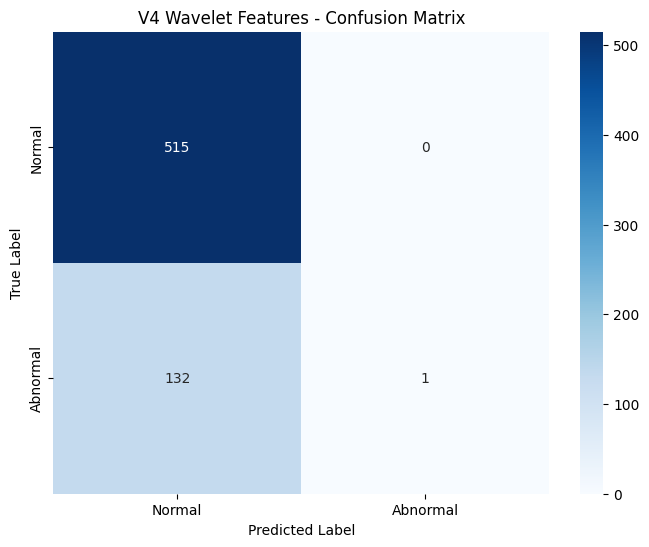

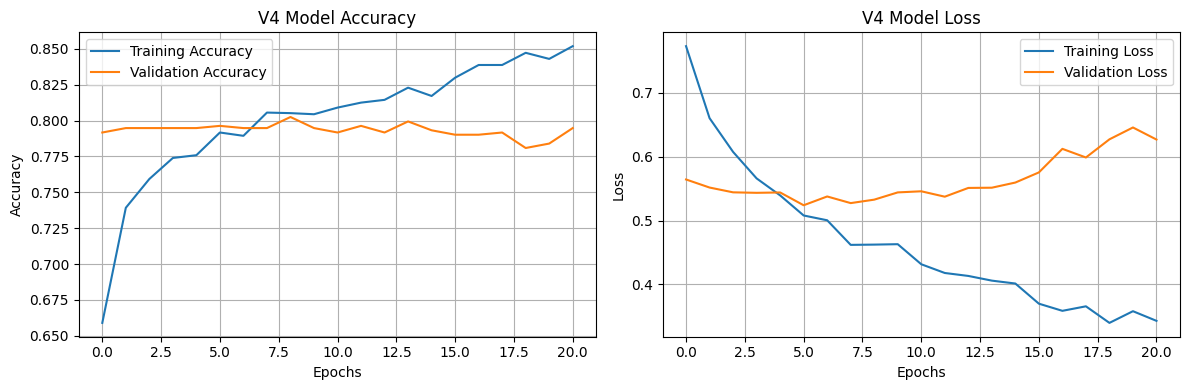


=== V4 Training Summary ===
Training stopped at epoch: 21
Best validation accuracy: 0.8025
Final test accuracy: 0.7963


In [8]:
# --- 5. Model Training & Evaluation ---
if len(X) > 0:
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    print("=== Starting V4 Model Training ===")
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=150, # Increased epochs for better training
        batch_size=32, 
        validation_data=(X_test_scaled, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    print("\n=== V4 Final Model Evaluation ===")
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test Loss: {loss:.4f}")

    # Make predictions for detailed analysis
    y_pred_proba = model.predict(X_test_scaled)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Classification report
    print("\n=== Detailed Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Abnormal']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Abnormal'], 
                yticklabels=['Normal', 'Abnormal'])
    plt.title('V4 Wavelet Features - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- Plotting Training History ---
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('V4 Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('V4 Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== V4 Training Summary ===")
    print(f"Training stopped at epoch: {len(history.history['loss'])}")
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Final test accuracy: {accuracy:.4f}")